In [1]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 14

### The Bootstrap and Confidence Intervals

## Question

- What is the median salary of San Diego city employees?
- All city employee salary data is public.

In [134]:
#: read in the data
population = Table.read_table('salaries.csv')
population

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Notes,Agency,Status
David P Gerboth,Fire Battalion Chief,81917,172590,68870,5194,323377,328571,2017,nan,San Diego,FT
Glen A Bartolome,Fire Captain,85904,120682,99408,10107,305994,316101,2017,nan,San Diego,FT
Scott C Chadwick,Chief Operating Officer,255000,0,31164,22688,286164,308852,2017,nan,San Diego,FT
David W Pilkerton,Fire Battalion Chief,100110,118798,62895,18746,281803,300549,2017,nan,San Diego,FT
Daniel S Reeves,Fire Captain,41389,196284,42027,20125,279700,299825,2017,nan,San Diego,PT
Edward S Jones,Fire Captain,46020,171896,59944,19669,277860,297529,2017,nan,San Diego,PT
Richard L Ballard,Fire Battalion Chief,99629,93528,61055,16630,254212,270842,2017,nan,San Diego,FT
Mark A Hovey,Retirement Administrator,240000,0,6190,21909,246190,268099,2017,nan,San Diego,FT
Adrian A Blackson,Fire Captain,44280,196978,16933,8304,258191,266495,2017,nan,San Diego,PT
Stacey D Lomedico,Asst Chief Oper Ofcr,215000,0,20352,30087,235352,265439,2017,nan,San Diego,FT


## The median salary

- We can use `np.median()`:

In [3]:
#...population_median
# the median of the "Total Pay" column
population_median = np.median(population.column('Total Pay'))
population_median

66665.5

## But now...

- ...suppose we don't have access to this data.
- It is costly and time-consuming to survey *all* 11,000+ employees.
- So we gather salaries for a random sample of, say, 500 people.
- Hope the median of the sample $\approx$ median of the population.

## In the language of statistics...

- The full table of salaries is the **population**.
- We observe a **sample** of 500 salaries from the population.
- We really want the population median, but we don't have the whole population.
- So we compute sample median as an **estimate**.
- Hopefully the sample median is close to the population median.

## The sample median

- Let's survey 500 employees at random.
- We can use `.sample()`:

In [4]:
#: take a sample of size 500
sample = population.sample(500, with_replacement=False)

In [5]:
#: compute the sample median
sample_median = np.median(sample.column('Total Pay'))
sample_median

65579.5

## How confident are we?

- Our estimate depended on a random sample.
- If our sample was different, our estimate would've been different, too.
- **How different could the estimate have been?**
- Our confidence in the estimate depends on the answer.

## The sample median is random

- The sample median is a random number.
- It comes from some distribution, which we don't know.
- How different could the estimate have been?
    - "Narrow" distribution $\Rightarrow$ not too different
    - "Wide" distribution $\Rightarrow$ quite different
- **What is the distribution of the sample median?**

## A (costly) approach

- Every sample of 500 people gives me one observation of the sample median.
- So draw a bunch of samples, compute medians.

In [71]:
#: imports for animation
from lecture import sampling_animation
from IPython.display import HTML

In [72]:
%%capture
anim, sample_medians = sampling_animation(population)

In [73]:
#: display animation
HTML(anim.to_jshtml())

## Visualize the distribution

- We can plot the distribution of the sample median with a histogram.
- This is an approximation using 128 samples.
- Sample median is usually in [62,000, 70,000].

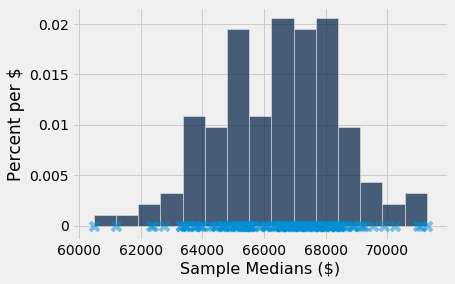

In [90]:
#: plot a histogram
Table().with_column('Sample Medians', sample_medians).hist(bins=15, unit='$')

# show each sample median as an 'x'
plt.scatter(sample_medians, np.zeros_like(sample_medians), marker='x', s=80, alpha=.5).set_zorder(2)

## The problem

- Drawing new samples like this is costly (why not just do a census?)
- Often, we can't ask for new samples from the population.
- The bootstrap:
    - the sample itself looks like the distribution.
    - so re-sampling from the sample is like drawing from the distribution.

In [56]:
#: a trick to plot the sample and the distribution side-by-side
bins=np.arange(10_000, 300_000, 10_000)
labels = ['Population']*population.num_rows + ['Sample']*sample.num_rows
together = population.append(sample).with_column('Labels', labels)

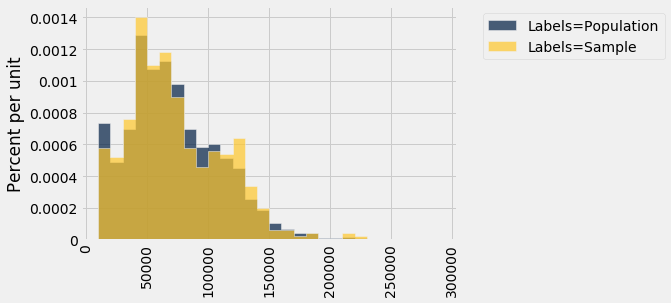

In [57]:
#: plot
together.hist('Total Pay', group='Labels', bins=bins)

## The bootstrap

- We have a sample of 500 salaries, we want another.
- Can't draw from the population.
- But the original sample looks like the population.
- So we re-sample the sample.

## Discussion question

Which of these effectively resamples the sample, simulating the drawing of a new sample of 500 people?

- A) `np.random.choice(sample, 500, replace=True)`
- B) `np.random.choice(sample, 500, replace=False)`
- C) `sample.sample(with_replacement=True)`
- D) `sample.sample(with_replacement=False)`

## Answer

- If we sample without replacement, we're just shuffling.
- So we sample *with* replacement to get something new.

## Running the bootstrap

- Now we can simulate new samples by bootstrapping
- I.e., we sample with replacement from our original sample

In [124]:
n_resamples = 5000

boot_medians = make_array()
for i in range(n_resamples):
    # perform bootstrap resampling
    resample = sample.sample(500, with_replacement=True)
    
    # compute the median
    median = np.median(resample.column('Total Pay'))
    
    # tack it on to our list of medians
    boot_medians = np.append(medians, median)

## Bootstrap distribution of the sample median

- Bulk of the time, the sample median is typically in [60,000, 70,000].
- Similar to what we found before.
- The population median (red dot) is near the middle.

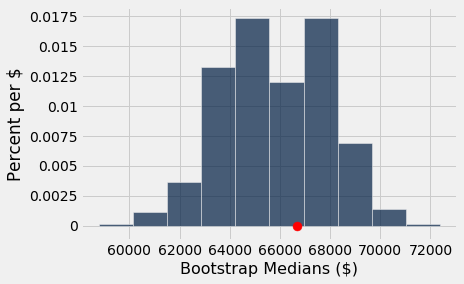

In [93]:
#: visualize
Table().with_column('Bootstrap Medians', medians).hist(unit='$')
plt.scatter(population_median, 0, color='red', s=80).set_zorder(2)

## Bootstrap rules of thumb

- The bootstrap is an awesome tool:
    - We used just one sample to get the (approximate) distribution of the sample median.
- But it has limitations:
    - Not good for sensitive statistics, like maximum.
    - Requires sample to be good approximation of population.
    - Works best when population is roughly bell-shaped.
    - Can be slow (recommend 10,000+ bootstrap samples)

## Example: boostrapping in the German tank problem

- Suppose the population consists of 400 tanks.
- We observe a random sample of 30 tanks.

In [139]:
#: 400 tanks
tank_population = Table().with_column('Serial Number', np.arange(400))

In [140]:
#: sample 30 tanks
np.random.seed(4242)
tank_sample = tank_population.sample(30, with_replacement=False)

## Running the bootstrap

- We want to estimate the maximum number in the population
- Our estimator will be the max in the sample.
- We run the bootstrap:

In [142]:
n_resamples = 5000

boot_maxes = make_array()
for i in range(n_resamples):
    # resample
    resample = tank_sample.sample(with_replacement=True)
    
    # compute max
    boot_max = resample.column('Serial Number').max()
    
    boot_maxes = np.append(boot_maxes, boot_max)

## Visualize

- The bootstrap distribution doesn't surround the right maximum of 399.

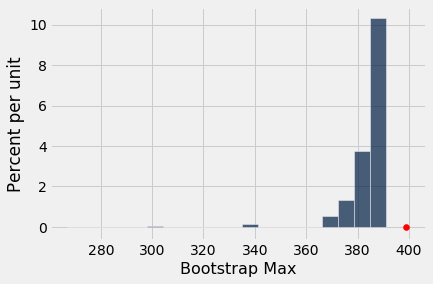

In [143]:
Table().with_column('Bootstrap Max', boot_maxes).hist(bins=20)
plt.scatter(399, 0, color='red')

# Confidence intervals

## Confidence intervals

- Bootstrapping approximates the distribution of an estimate
- The true value typically lies within bulk of the distribution
- We can give an interval that we are confident that the correct value lies within

## A 95% confidence interval for median salary

- Recall our bootstrap distribution of the sample median
- Suppose by "bulk", we mean containing the middle 95% of the area.

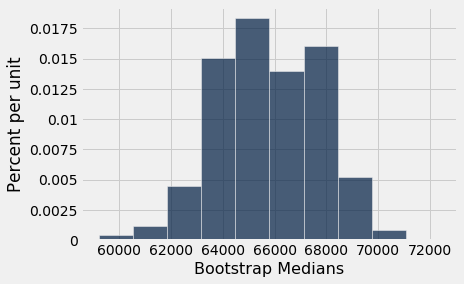

In [147]:
#: visualize
Table().with_column('Bootstrap Medians', boot_medians).hist()

## Finding the endpoints

- We want to find two points, $x$ and $y$, such that the area:
    - to the left of $x$ is about 2.5%
    - to the right of $y$ is about 2.5%
- Then the interval $[x,y]$ will have about 95% of the total area
- I.e., we want the 2.5th percentile and 97.5th percentile.

## Computing percentiles

- Use `percentile()` function:
    - First arg: percentile to find as # in [0, 100]
    - Second arg: array of values

In [148]:
#...left
left = percentile(2.5, boot_medians)
left

61929.0

In [152]:
#...right
right = percentile(97.5, boot_medians)
right

69303.5

In [155]:
#: our interval is
[left, right]

[61929.0, 69303.5]

## Visualizing our 95% confidence interval

- Let's draw the interval on the histogram.
- 95% of the bootstrap medians fell into this interval.

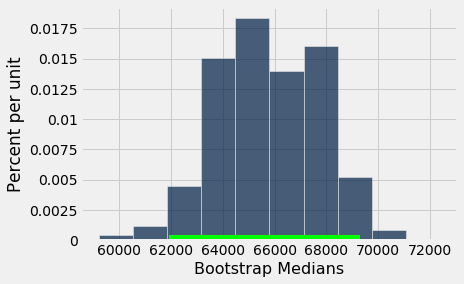

In [163]:
#: visualize
Table().with_column('Bootstrap Medians', boot_medians).hist()
plt.plot([left, right], [0, 0], color='lime', linewidth=10)

## Discussion question

Would an 80% confidence interval be bigger, smaller, or the same size?

- A) Bigger
- B) Smaller
- C) The same size

## Discussion Question

Suppose you had the true distribution of the sample median and used it to compute a 100% confidence interval. And suppose you compute a 100% confidence interval using the bootstrap. Which is bigger?

- A) The first confidence interval (from the true distribution).
- B) The second confidence interval (from the boostrap).
- C) They're the same size.

## Interpreting confidence intervals

- 95% of our bootstrap medians fell within this interval
- We're pretty confident that the true median does, too.
- How confident should we be about this?

## Capturing the correct value

- If we run the bootstrap again, we get a different distribution.
- And so we get a different 95% confidence interval.
- 95% of the time, the interval will capture the correct median.

## Interpreting confidence intervals

- Doesn't have to be for same experiment!
- Suppose you only ever make 95% confidence intervals.
- Then roughly 95% of the CIs you make in your life will contain the true value of the thing being estimated.

## Misinterpreting confidence intervals

- A 95% confidence interval has a 95% chance of containing the true value of the thing being estimated.
- The interval is random, not the thing being estimated!

## Misinterpreting confidence intervals

- Our 95% confidence interval for the median salary was:

In [188]:
#: remember...
[left, right]

[61929.0, 69303.5]

- This does not mean that 95% of salaries are in this range!

## Example: Estimating proportions

- Can use the bootstrap to get confidence intervals on other things.
- Such as: proportions.

In [259]:
#: the people in 
this_section = Table.read_table('eldridge.csv')
this_section

College,Major,Level
MU,DS25,SO
WA,DS25,SR
FI,MA27,SR
RE,EN28,SO
FI,PS25,FR
SI,DS25,SO
RE,DS25,FR
WA,CE25,SR
MU,DS25,JR
MU,EN26,SO


## Discussion Question

What is the most popular college in this section?

- A) Sixth
- B) Warren
- C) Revelle
- D) Marshall

## Answer

In [260]:
this_section.group('College')

College,count
FI,17
GR,1
MU,13
RE,18
SI,30
TH,24
WA,36


## Estimation

- The proportion of students in Warren is...
- This is an *estimate* of the proportion in the population.
- But what is the population?

In [261]:
proportion = this_section.where('College', 'WA').num_rows / first_section.num_rows
proportion

0.2589928057553957

## Bootstrapped confidence interval

- Let's bootstrap a 95% CI for the proportion

In [262]:
#: run the bootstrap
n_resamples = 5000

boot_props = make_array()
for i in range(n_resamples):
    resampled = this_section.sample(with_replacement=True)
    boot_prop = resampled.where('College', 'WA').num_rows / resampled.num_rows
    boot_props = np.append(boot_props, boot_prop)

## Visualizing the distribution

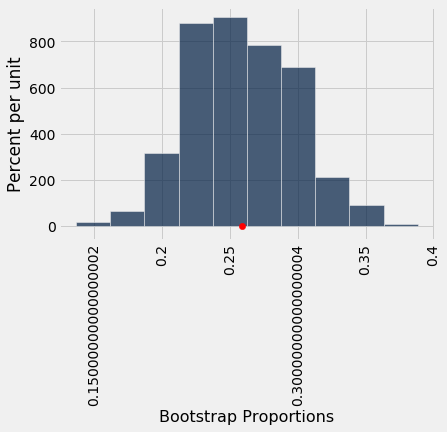

In [263]:
#: visualize
Table().with_columns('Bootstrap Proportions', boot_props).hist()
plt.scatter(proportion, 0, color='red', s=40).set_zorder(2)

## Computing the confidence interval

In [264]:
#: left endpoint
left = percentile(2.5, boot_props)
left

0.18705035971223022

In [265]:
#: right endpoint
right = percentile(97.5, boot_props)
right

0.3381294964028777

In [266]:
#: the interval
[left, right]

[0.18705035971223022, 0.3381294964028777]

## Visualizing the confidence interval

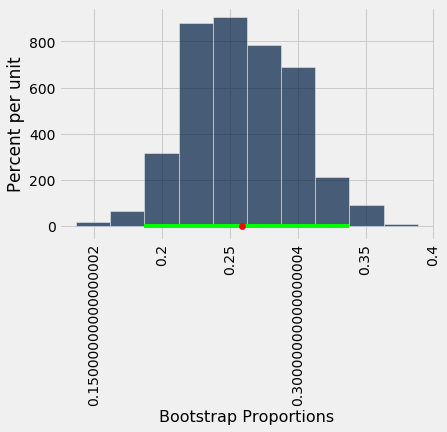

In [313]:
#: visualize
Table().with_columns('Bootstrap Proportions', boot_props).hist()
plt.scatter(proportion, 0, color='red', s=40).set_zorder(3)
plt.plot([left, right], [0, 0], color='lime')

## The other section

- If other section drawn from same population, its proportion is likely to be in this interval.
- Why? The interval was made by simulating draws from the population.

In [267]:
#: compute proportion in Warren for other section
other_section = Table.read_table('fraenkel.csv')
other_proportion = other_section.where('College', 'WA').num_rows / other_section.num_rows
other_proportion

0.17482517482517482

In [290]:
#: remember the interval
[left, right]

[0.18705035971223022, 0.3381294964028777]

## Are they from the same distribution?

- A/B test!
- New columns:
    - "Warren": True/False, if in Warren.
    - "Section": 'This' or 'Other'

In [291]:
#: adding columns...
this_section_in_warren = this_section.with_columns(
    'Warren',
    this_section.column('College') == 'WA',
    'Section',
    'This'
)

other_section_in_warren = other_section.with_columns(
    'Warren',
    other_section.column('College') == 'WA',
    'Section',
    'Other'
)

## Combine the sections

In [292]:
#: combine the sections
combined = this_section_in_warren.append(other_section_in_warren)
combined = combined.select('Warren', 'Section')
combined

Warren,Section
False,This
True,This
False,This
False,This
False,This
False,This
False,This
True,This
False,This
False,This


## Statistic

- The difference between the group proportions

In [304]:
#: the difference in proportion between groups
def statistic(combined):
    group_proportions = combined.group('Section', np.mean).column('Warren mean')
    return group_proportions.item(1) - group_proportions.item(0)

## Permutation test

In [305]:
#: permutation test
n_shuffles = 5000

differences = make_array()
for i in range(n_shuffles):
    shuffled_sections = combined.sample(with_replacement=False).column('Section')
    shuffled = combined.with_column('Section', shuffled_sections)
    difference = statistic(shuffled)
    differences = np.append(differences, difference)

## Visualize

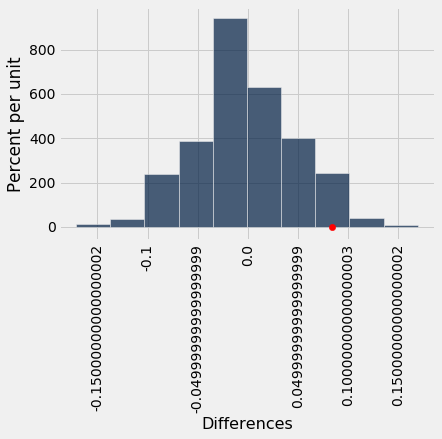

In [306]:
#: visualize
Table().with_column('Differences', differences).hist()
plt.scatter(statistic(combined), 0, color='red', s=40).set_zorder(2)

## Calculate a p-value

In [309]:
#: the p-value
np.count_nonzero(differences >= statistic(combined)) / len(differences)

0.0538